In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from brokenaxes import brokenaxes

mpl.rcParams['font.size'] = 8

In [5]:
from scipy.signal import savgol_filter, find_peaks

In [6]:
def pseudo_voigt(x, mu, gamma_gaussian, gamma_lorentzian, amplitude, eta):
    """ 
    Voigt profile approximation by linear combination of
    Lorenzian and Gaussian distributinos.
    mu, A, A0, FWHM, eta
    """
    a_G = (2 / gamma_gaussian) * np.sqrt(np.log(2) / np.pi)
    b_G = (4 * np.log(2)) / (gamma_gaussian**2)
    gaussian_term = a_G * np.exp(-b_G * (x - mu)**2)
    
    lorentzian_term = (1 / np.pi) * ( (gamma_lorentzian / 2) / ( (x - mu)**2 + (gamma_lorentzian / 2)**2) ) 
    
    result = amplitude * (eta * gaussian_term + (1 - eta) * lorentzian_term)

    return result

In [7]:
x_values = np.linspace(0, 100, 1000)
y_values = (
            np.exp(-(x_values - 20)**2 / (2 * 5**2)) +
            np.exp(-(x_values - 25)**2 / (2 * 2**2)) +
            np.exp(-(x_values - 30)**2 / (2 * 2**2)) +
            np.exp(-(x_values - 50)**2 / (2 * 5**2)) +
            np.exp(-(x_values - 75)**2 / (2 * 3**2)) +
            np.exp(-(x_values - 80)**2 / (2 * 2**2)) + 
            np.random.normal(0, 0.001, x_values.size)
            )

In [8]:
df = pd.read_csv("~/data/dataset.csv")
wn = pd.read_csv("~/data/domain.csv").to_numpy().reshape(-1)
X = df.drop(columns=['HbA1c', 'years'])
X.columns = wn


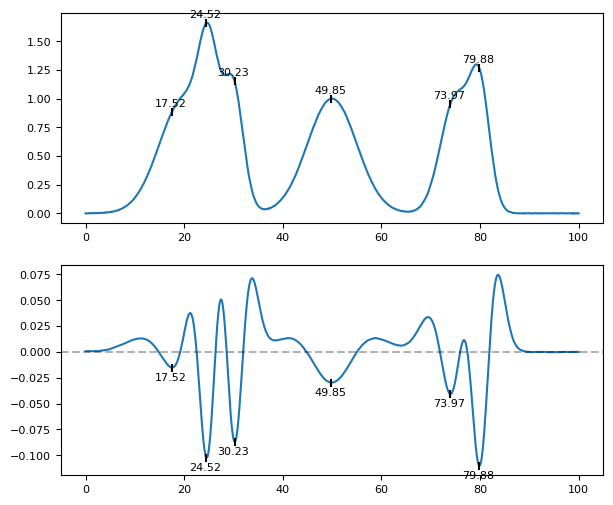

In [9]:
def peaks_second_deriv(x_values, 
                       y_values, 
                       window_length=10,
                       polyorder=2,
                       **kwargs):
    
    first_deriv = savgol_filter(y_values, window_length=window_length, polyorder=polyorder, deriv=1)
    second_deriv = savgol_filter(y_values, window_length=window_length, polyorder=polyorder, deriv=2)
    second_deriv = second_deriv / np.linalg.norm(second_deriv)
    peaks = find_peaks(-second_deriv, **kwargs)[0]

    fig, axs = plt.subplots(2, 1, figsize=(7, 6))
    axs[0].plot(x_values, y_values)
    axs[0].scatter(x_values[peaks], y_values[peaks], color='k', marker='|', linewidth=1.5, zorder=5)

    for peak in peaks:
        peak_pos = x_values[peak]
        axs[0].annotate(f'{peak_pos:.2f}', 
                        xy=(peak_pos, y_values[peak]), 
                        xytext=(peak_pos - 3.5, y_values[peak] + 0.1 * y_values.mean()),
                        fontsize=8
                        )

    axs[1].plot(x_values, second_deriv)
    axs[1].scatter(x_values[peaks], second_deriv[peaks], color='k', marker='|', linewidth=1.5, zorder=5)
    axs[1].axhline(y=0, linestyle="--", alpha=0.3, color='k')

    for peak in peaks:
        peak_pos = x_values[peak]
        axs[1].annotate(f'{peak_pos:.2f}', 
                        xy=(peak_pos, second_deriv[peak]), 
                        xytext=(peak_pos - 3.5, second_deriv[peak] - 0.6 * np.abs(second_deriv).mean()),
                        fontsize=8
                        )
        
    peak_results = pd.DataFrame({
        "Index": peaks,
        "Value": [int(x_values[peak]) for peak in peaks]
    })

    plt.show()

    return

peaks_second_deriv(x_values, 
                   y_values, 
                   window_length=50, 
                   height=0.001, 
                   prominence=0.0001, 
                   distance=20)

In [10]:
sample = X.mean()
sample = sample[(sample.index >= 1600) & (sample.index <= 1730)]

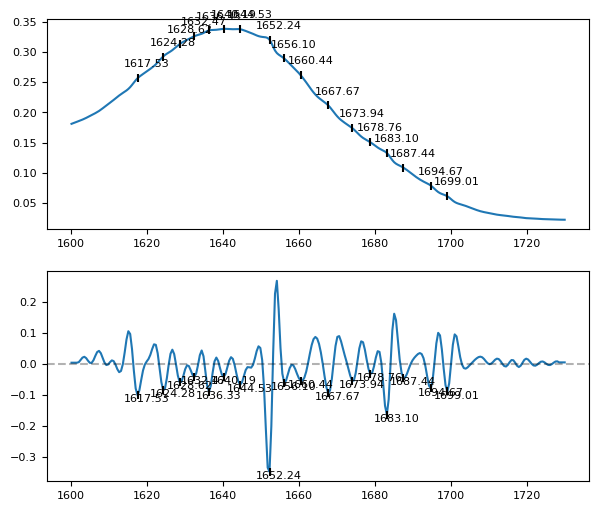

In [11]:
peaks_second_deriv(sample.index.to_numpy(), 
                   sample.to_numpy(), 
                   window_length=7,
                   polyorder=2,
                   height=0.03, 
                   prominence=0.00001, 
                   distance=7)

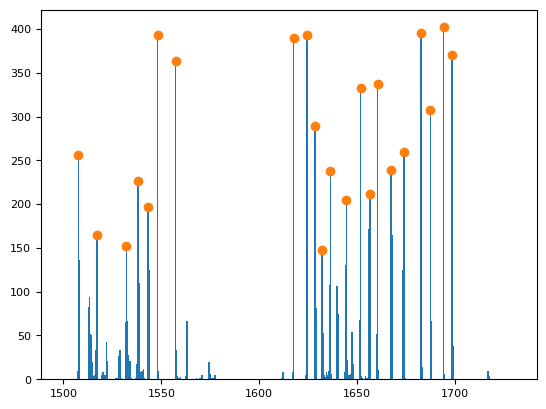

In [12]:
def find_peaks_matrix(domain,
                      absorbance,
                      window_length=10,
                      polyorder=2,
                      threshold=0.5,
                      **kwargs):
    
    n_samples, n_features = absorbance.shape
    
    X_deriv = absorbance.T.apply(lambda col: savgol_filter(col, 
                                                           window_length=window_length, 
                                                           polyorder=polyorder, 
                                                           deriv=2)).T
    X_deriv = X_deriv.apply(lambda row: row / np.linalg.norm(row), axis=1)

    total_peaks = np.zeros(n_features)


    for index, row in X_deriv.iterrows():
        peaks = find_peaks(-row, **kwargs)[0]
        total_peaks[peaks] += 1


    peaks_counts, *_ = find_peaks(total_peaks, height=int(n_samples * threshold))
    plt.bar(domain, total_peaks)
    plt.scatter(domain[peaks_counts], total_peaks[peaks_counts])
    # plt.xlim([1600, 1730])
    plt.show()

    # print(peaks_counts.shape)
    # absorbance.T.plot(legend=False)
    # plt.scatter(domain[peaks_counts], absorbance.mean().to_numpy()[peaks_counts])

    return domain[peaks_counts]

X_amide1 = X.iloc[:, (X.columns >= 1500) & (X.columns <= 1730)]

peaks_amides = find_peaks_matrix(X_amide1.columns.to_numpy(), 
                  X_amide1, 
                   window_length=10, 
                   height=0.03, 
                   prominence=0.0001, 
                   distance=7,
                   threshold=0.3)

<Axes: >

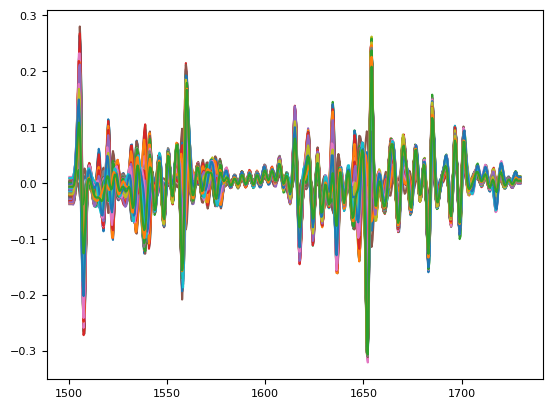

In [13]:
X_deriv = X_amide1.T.apply(lambda col: savgol_filter(col, window_length=7, polyorder=2, deriv=2)).T
X_deriv = X_deriv.apply(lambda row: row / np.linalg.norm(row), axis=1)
X_deriv.T.plot(legend=False)

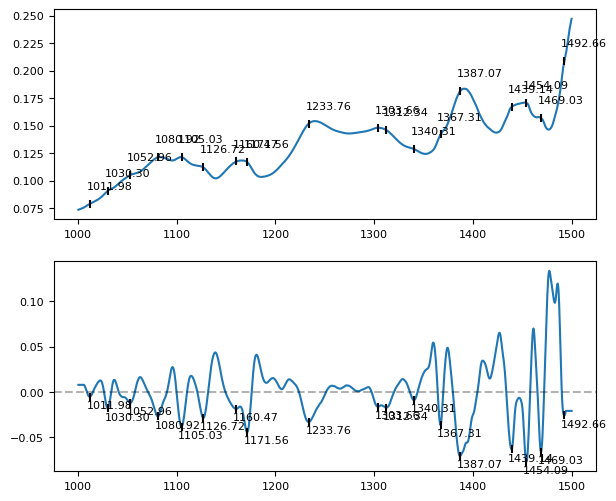

In [14]:
sample = X.mean()
sample = sample[(sample.index >= 1000) & (sample.index <= 1500)]

peaks_second_deriv(sample.index.to_numpy(), 
                   sample.to_numpy(), 
                   window_length=25, 
                   polyorder=2,
                   height=0.001, 
                   prominence=0.00001, 
                   distance=10)

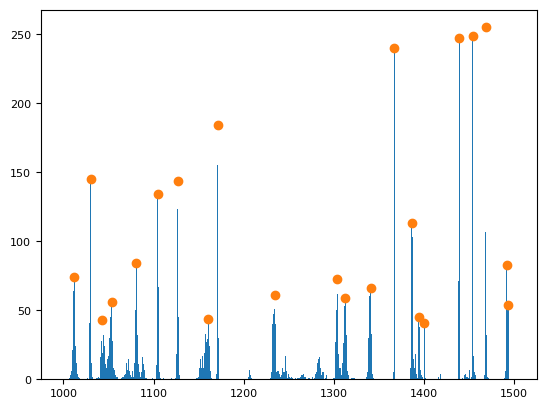

In [15]:
X_1000_1500 = X.iloc[:, (X.columns >= 1000) & (X.columns <= 1500)]

peaks_1000_1500 = find_peaks_matrix(X_1000_1500.columns.to_numpy(), 
                X_1000_1500, 
                window_length=25, 
                height=0.001, 
                prominence=0.0001, 
                distance=7,
                threshold=0.1
                )

<Axes: >

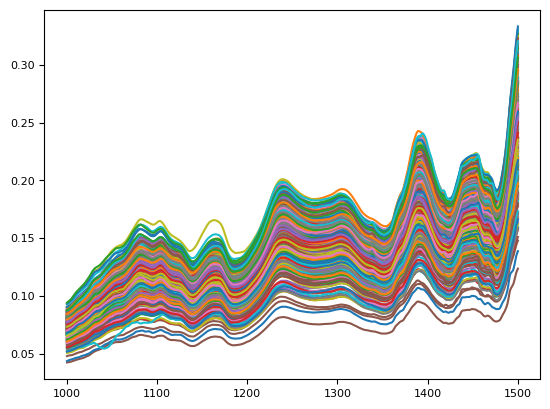

In [16]:
X_1000_1500.T.plot(legend=False)

In [17]:
len(peaks_amides)

22

In [18]:
len(peaks_1000_1500)

22

In [19]:
peaks = np.concatenate([peaks_1000_1500, peaks_amides])

# pd.Series(peaks).to_csv('peaks.csv', index=False)
peaks

array([1011.98 , 1030.3  , 1042.836, 1053.442, 1080.923, 1104.547,
       1127.207, 1160.956, 1171.563, 1234.721, 1303.665, 1312.343,
       1340.789, 1367.305, 1386.59 , 1394.304, 1400.572, 1439.142,
       1454.088, 1469.034, 1491.693, 1493.14 , 1507.604, 1517.246,
       1532.192, 1537.978, 1543.281, 1548.102, 1557.262, 1617.528,
       1624.278, 1628.617, 1631.992, 1636.331, 1644.527, 1651.759,
       1656.58 , 1660.437, 1667.187, 1673.937, 1682.615, 1687.436,
       1694.186, 1698.525])

In [20]:
wavenumber_mask = ((X.columns >= 1000) & (X.columns <= 3700)) & ~((X.columns > 1800) & (X.columns < 2700))
X = X.iloc[:, wavenumber_mask]
X.head(10)

Text(0, 0.5, 'Absorbance')

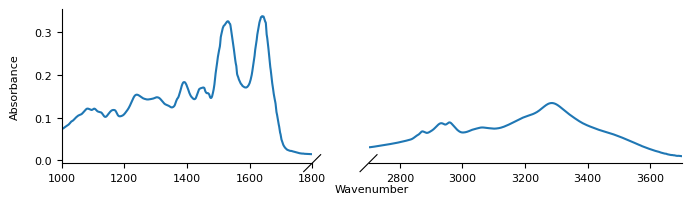

In [22]:
fig = plt.figure(figsize=(8, 2))
bax = brokenaxes(xlims=((1000, 1800), (2700, 3700)))

wn = X.columns
absorbance = X.mean()

bax.plot(wn, absorbance)
# bax.legend(loc=3)
bax.set_xlabel('Wavenumber')
bax.set_ylabel('Absorbance')